In [1]:
import os
import sys
import psutil

import pandas as pd
import numpy as np

import keras
import random

from keras.models import Sequential,Model
from keras.layers import Dense,LSTM,Activation,Dropout,BatchNormalization,Input,Embedding
from keras.layers import Flatten,Conv2D,MaxPooling2D,Bidirectional,concatenate

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import optimizers
import keras_metrics as km

import matplotlib
import matplotlib.pyplot as plt
import math
from multiprocessing import cpu_count,Pool 
import multiprocessing


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.utils import np_utils
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import make_scorer
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import roc_curve, auc

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from keras_self_attention import SeqSelfAttention


/usr/local/anaconda5/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    weights = K.variable(weights)      
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [3]:
SEQ=8
verbose = 2
dropout=0.3
ACT_POSTERIOR = 'relu'
weights = np.array([0.2,0.8])
patience = 10
weight_decay = 0.0001
lr=0.1
lr_decay=1e-6

LSTM_UNIT = 128
GEOHASH_UNIT = 32
EMBEDDING_UNIT = 128
NLP_UNIT = 128
SEQ_UNIT = 256
ACT_PRIOR = 'sigmoid'
DENSE_CONCAT = 256
VAL_SPLIT = 0.2
CONV_UNIT = 32
ADD_ON_LAYERS = True
Embedding_outdim = 100

In [4]:
def reshape_cat(array,category):
    l=[]
    b = array[:,0:-14]
    if category!='geohash' and  category!='NLP' :
        for i in range(SEQ):
            c = b[:,i*25:i*25+25]
            if category == 'traffic':
                #d = np.concatenate((c[:,0:9],c[:,-5:]),axis=1)
                d = np.concatenate([c[:,1:2],c[:,3:10]],axis=1)
            elif category=='weather':
                d = c[:,10:-5]
            elif category=='time':
                d = np.concatenate([c[:,0:1],c[:,2:3],c[:,-5:]],axis=1) 
            else:
                d = c
            l.append(d)        
        n = np.concatenate(l,axis=1)
        #if category!='no_geohash':
        #    return np.concatenate((n,array[:,-14:]),axis=1)
        return n
    elif category=='NLP':
        return array[:,-100:]
    else:
        return array[:,-114:-100]

In [5]:
# Compute ROC curve and ROC area for each class
def roc_auc_compute(y_test,y_score,n_classes=2):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i],pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel(),pos_label=1)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return fpr,tpr,roc_auc
def plot_roc(fpr,tpr,roc_auc,n_classes=2):
    lw = 2
# Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(2)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
class base_model(object):        
    def __init__(self,n_jobs=10,act=ACT_POSTERIOR,city='Atlanta'): 
        self.n_jobs=n_jobs
        self.CITY=city
        self.act=act
   
    def load_data(self,category=None,with_geocode=False):
        self.X_train = np.load('train_set/X_train_'+self.CITY+'.npy')
        self.y_train = np.load('train_set/y_train_'+self.CITY+'.npy')
        self.X_test = np.load('train_set/X_test_'+self.CITY+'.npy')
        self.y_test = np.load('train_set/y_test_'+self.CITY+'.npy')
        
        if not with_geocode:
            self.X_train = self.X_train[:,0:-1]    
            self.X_test = self.X_test[:,0:-1]     
        self.update_y()   
        
        if category!=None:
            l_train=[]
            l_test=[]
            for cat in category:
                l_train.append(reshape_cat(self.X_train,cat))
                l_test.append(reshape_cat(self.X_test,cat))
            self.X_train = np.concatenate(l_train,axis=1)
            self.X_test = np.concatenate(l_test,axis=1)
        
        print ('load and test: shapes for train and test, X/Y')
        print (self.X_train.shape)
        print (self.y_train.shape)
        print (self.X_test.shape)
        print (self.y_test.shape)
    
    def update_y(self):
        self.y_train = to_categorical(self.y_train,2)
        self.y_test = to_categorical(self.y_test,2)
    def last_layers(self,model_in):
        model_in = Dense(DENSE_CONCAT,
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=self.act)(model_in)
        
        model_in = Dense(units=int(DENSE_CONCAT/2),
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=None)(model_in)
        if ADD_ON_LAYERS:
            model_in = BatchNormalization()(model_in)
        model_in = Activation(self.act)(model_in)
        model_in = Dropout(dropout)(model_in)
        
        model_in = Dense(units=int(DENSE_CONCAT/8),
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=None)(model_in)
        if ADD_ON_LAYERS:
            model_in = BatchNormalization()(model_in)
        model_in = Activation(self.act)(model_in)
        #model_in = Dropout(dropout)(model_in)
        ######################################
        main_output = Dense(self.output_dim, activation=self.activation)(model_in)
        return main_output
        
class keras_model(base_model):
    def __init__(self,city='Atlanta',activation='softmax',batch_size=256,epoch = 60,n_jobs=1,act=ACT_POSTERIOR):
        super(keras_model,self).__init__(act=act,city=city)
        self.output_dim = 2
        self.activation=activation
        self.batch_size = batch_size
        self.epoch = epoch
        self.n_jobs=n_jobs
        self.weight_decay = weight_decay
        self.lr=lr
        self.lr_decay=lr_decay
        
    def reshape(self,x):
        x = x[:,0:-114]
        x = x.reshape((x.shape[0],SEQ,int(x.shape[1]/SEQ)))
        return x
    
    def compile_model(self,model=None):
        #precision = km.categorical_precision(label=1)
        #recall = km.categorical_recall(label=1)
        f1_score = km.categorical_f1_score(label=1)
        self.earlyStopping = EarlyStopping(monitor='val_f1_score', 
                                           #monitor = 'val_categorical_f1_score',
                                           restore_best_weights=True,
                                           patience=patience, verbose=0, mode='max'#,baseline=0.1
                                          )
        adam  = optimizers.Adam(lr=self.lr, decay=self.lr_decay)
        loss=weighted_categorical_crossentropy(weights)
        self.model.compile(optimizer=adam, loss=loss#'categorical_crossentropy'
                           ,metrics=[f1_score])
    def create_model(self):
        self.model = KerasClassifier(build_fn=self.build_model, epochs=self.epoch, batch_size=self.batch_size, verbose=1)
    def make_report(self,y_true,y_pred):
        data_frame = classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),output_dict=True)
        df = pd.DataFrame(data_frame)
        df = df.reset_index()
        roc_dict = self.roc_auc(y_true,y_pred)
        df = df.append({'index':'auc','0': roc_dict[0], '1': roc_dict[1],
                   'micro avg': roc_dict['micro'],
                   'macro avg':roc_dict['macro']}, ignore_index=True)
        df = df.set_index('index')
        display(df)
        return df
        
    def roc_auc(self,y_test,y_score):
        fpr,tpr,roc_auc = roc_auc_compute(y_test,y_score)
        plot_roc(fpr,tpr,roc_auc)
        return roc_auc
         
        

In [17]:
class model_LSTM_aug_embed(keras_model):
    
    def load_data(self):
        super(model_LSTM_aug_embed,self).load_data(with_geocode=True)
        
        self.X_train1 = self.reshape(self.X_train[:,:-1])
        self.X_test1 = self.reshape(self.X_test[:,:-1])
        
        self.X_train2 = reshape_cat(self.X_train[:,:-1],'geohash')
        self.X_train3 = reshape_cat(self.X_train[:,:-1],'NLP')
        
        self.X_test2 = reshape_cat(self.X_test[:,:-1],'geohash')
        self.X_test3 = reshape_cat(self.X_test[:,:-1],'NLP')
        
        self.X_train4 = self.X_train[:,-1]
        self.X_test4 = self.X_test[:,-1]
        
        print (self.X_train1.shape)
        print (self.X_train2.shape)
        print (self.X_train3.shape)
        print (self.X_train4.shape)
        return self.X_train4,self.X_test4
        
    def create_model(self):
        
        input1 = Input(shape=(self.X_train1.shape[1], self.X_train1.shape[2]),dtype='float32', 
                           name='main_input')
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(input1)
        
        lstm = LSTM(units = LSTM_UNIT, return_sequences = False,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(lstm)
        ######################################
        input2 = Input(shape=(self.X_train2.shape[1],), dtype='float32', name='geohash_input')
        geohash_vec = Dense(GEOHASH_UNIT, activation=ACT_PRIOR)(input2)
        ######################################
        input3 = Input(shape=(self.X_train3.shape[1],), dtype='float32', name='nlp_input')
        nlp_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(input3)
        ######################################
        input4 = Input(shape=(1,),dtype='int32',name='geo_code')
        embeding = Embedding(input_dim=935, output_dim=Embedding_outdim, embeddings_initializer='uniform',input_length=1,name='embedding')(input4)
        embeding = Flatten()(embeding)
        embeding = Dense(EMBEDDING_UNIT, activation=ACT_PRIOR)(embeding)
        ######################################
        level_3 = concatenate([lstm,geohash_vec,nlp_vec,embeding])
        
        main_output = self.last_layers(level_3)
        
        self.model = Model(inputs=[input1,input2,input3,input4], outputs=main_output)
        
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit([self.X_train1,self.X_train2,self.X_train3,self.X_train4], self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict([self.X_test1,self.X_test2,self.X_test3,self.X_test4],verbose=verbose)
        return self.make_report(y_true, y_pred)
    
    def get_embedding(self):
        return self.model.layers[2].get_weights()[0]
        
        


In [21]:

    
def compare_models(city='Atlanta',vr=2,drop=0.2,val_split=0.2,p=15,w_d=0,LR=0.01,lr_dc=1e-6,
                   add_on_layer=True,
                   w=[1,4],
                   act_prior = 'sigmoid',act_posterior='relu',
                   lstm_unit=128,geohash_unit=128,embedding_unit=128,nlp_unit=128,seq_unit=256,
                   dense_concat=512,conv_unit=32,
                  ):

    #global SEQ=8
    global verbose
    global dropout
    global ACT_POSTERIOR
    global ACT_PRIOR
    global weights
    global patience
    global weight_decay
    global lr
    global lr_decay
    
    global GEOHASH_UNIT
    global EMBEDDING_UNIT 
    global NLP_UNIT
    global SEQ_UNIT
    
    global LSTM_UNIT
    global DENSE_CONCAT
    global CONV_UNIT
    global ADD_ON_LAYER
    global VAL_SPLIT
    global Embedding_outdim
    verbose = vr
    dropout=drop
    weights = np.array(w)
    patience = p
    weight_decay = w_d
    lr=LR
    lr_decay=lr_dc
    
    ACT_PRIOR = act_prior
    ACT_POSTERIOR = act_posterior
    
    LSTM_UNIT = lstm_unit
    GEOHASH_UNIT = geohash_unit
    EMBEDDING_UNIT = embedding_unit
    NLP_UNIT = nlp_unit
    SEQ_UNIT = seq_unit
    DENSE_CONCAT = dense_concat
    CONV_UNIT = conv_unit
    Embedding_outdim = embedding_unit
    
    ADD_ON_LAYER = add_on_layer
    VAL_SPLIT = val_split
    def initialte_class(classname):
        if classname=='DNN':
            mypred = DNN(city=city)
            return mypred
        if classname=='DNN_embed':
            mypred = DNN_embed(city=city)
            return mypred
        if classname=='RNN':
            mypred = model_LSTM_aug(city=city)
            return mypred
        if classname=='RNN_embed':
            mypred = model_LSTM_aug_embed(city=city)
            return mypred
        if classname=='ATT':
            mypred = model_LSTM_aug_embed_att(city=city)
            return mypred
        print ('error in name')
        raise
        return None        
    def do_rest(pred):
        embed_train, embed_test = pred.load_data()
        pred.create_model()
        pred.compile_model()
        pred.train()
        embeding_vec = pred.get_embedding()
        return pred,embeding_vec,embed_train
    
    def process_frame(df,i):
        new_df = df[['0','1','weighted avg']].drop('support',axis=0)
        new_df=new_df.stack().swaplevel()
        new_df.index=new_df.index.map('{0[0]}_{0[1]}'.format) 
        new_df = new_df.to_frame().T
        new_df['run'] = i
        new_df = new_df.set_index('run')
        return new_df
    def rerun(classname):
        df_list=[]
        for i in range(1):
            print ("*"*20,classname,"*"*20)
            print ('*'*10,' round ', i)
            mypred = initialte_class(classname)
            mypred,embed_vec,geo_index = do_rest(mypred)
            res  = mypred.evaluate()
            df_list.append(process_frame(res,i))
        df = pd.concat(df_list)
        return pd.DataFrame(df.mean(),columns=[classname]),embed_vec,geo_index
    def make_dic(embed_vec,geo_index):
        dict_={}
        for idx in geo_index:
            dict_[idx] = embed_vec[idx]
        return dict_
    list_res=[]
    res,embed_vec,geo_index = rerun('RNN_embed')
    dict_ = make_dic(embed_vec,geo_index)
    list_res.append(res)
    #list_res.append(rerun('ATT'))
    return pd.concat(list_res,axis=1),dict_
        
    

In [31]:
import pickle

def save_dict(dict_,name='name'):
    f = open('./pickle/'+name+'.pkl',"wb")
    pickle.dump(dict_,f)
    f.close()

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(12085, 315)
(12085, 2)
(2515, 315)
(2515, 2)
(12085, 8, 25)
(12085, 14)
(12085, 100)
(12085,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

 - 2s - loss: 0.2742 - f1_score: 0.6372 - val_loss: 0.3794 - val_f1_score: 0.4139
Epoch 34/60
 - 2s - loss: 0.2748 - f1_score: 0.6447 - val_loss: 0.3427 - val_f1_score: 0.3580
Epoch 35/60
 - 2s - loss: 0.2710 - f1_score: 0.6436 - val_loss: 0.3442 - val_f1_score: 0.3887
Epoch 36/60
 - 2s - loss: 0.2728 - f1_score: 0.6378 - val_loss: 0.3522 - val_f1_score: 0.3647


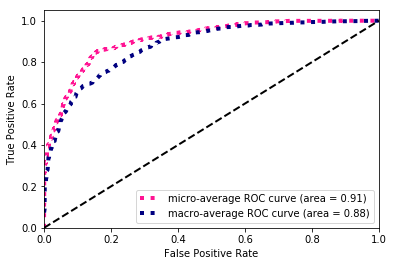

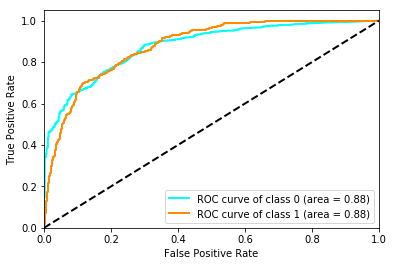

,0,1,macro avg,micro avg,weighted avg
index,,,,,
f1-score,0.901250,0.651665,0.776458,0.846123,0.848555
precision,0.912661,0.624138,0.768400,0.846123,0.851745
recall,0.890121,0.681733,0.785927,0.846123,0.846123
support,1984.000000,531.000000,2515.000000,2515.000000,2515.000000
auc,0.878363,0.878362,0.878829,0.910274,NaN


In [22]:
Atlanta,dict_ = compare_models(w=[1,1])

In [25]:
save_dict (dict_,'Atlanta')

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 315)
(30862, 2)
(6132, 315)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

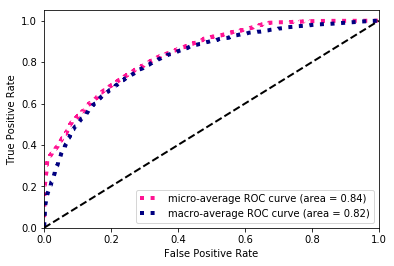

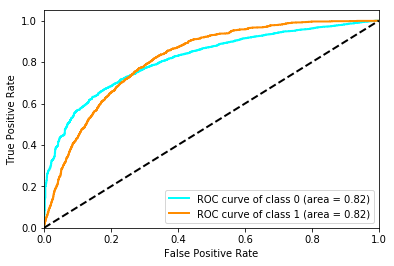

,0,1,macro avg,micro avg,weighted avg
index,,,,,
f1-score,0.821612,0.551704,0.686658,0.744781,0.762762
precision,0.905983,0.447075,0.676529,0.744781,0.805924
recall,0.751616,0.720269,0.735943,0.744781,0.744781
support,4795.000000,1337.000000,6132.000000,6132.000000,6132.000000
auc,0.816726,0.816727,0.816942,0.840389,NaN


In [26]:
LosAngeles,dict_  =compare_models('LosAngeles',w=[1,1])
save_dict (dict_,'LosAngeles')

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 315)
(22890, 2)
(4664, 315)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

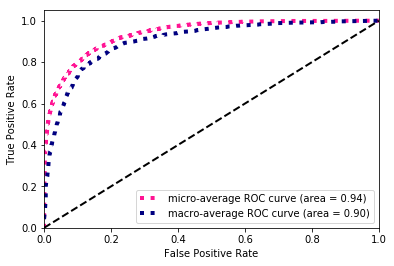

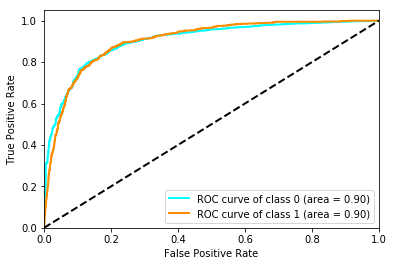

,0,1,macro avg,micro avg,weighted avg
index,,,,,
f1-score,0.908796,0.649715,0.779255,0.855274,0.864301
precision,0.950537,0.555950,0.753244,0.855274,0.882770
recall,0.870567,0.781523,0.826045,0.855274,0.855274
support,3863.000000,801.000000,4664.000000,4664.000000,4664.000000
auc,0.903491,0.903491,0.903751,0.937275,NaN


In [27]:
Austin,dict_  =compare_models('Austin',w=[1,1])
save_dict (dict_,'Austin')

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 315)
(7671, 2)
(1561, 315)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________


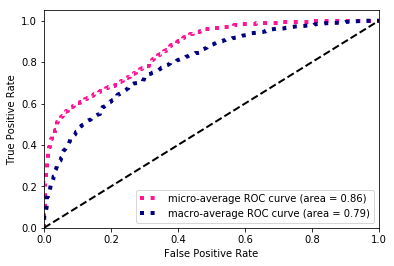

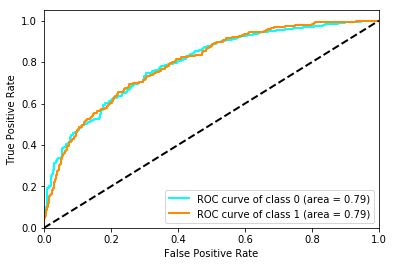

,0,1,macro avg,micro avg,weighted avg
index,,,,,
f1-score,0.826271,0.461942,0.644107,0.737348,0.766289
precision,0.923295,0.348515,0.635905,0.737348,0.828665
recall,0.747699,0.684825,0.716262,0.737348,0.737348
support,1304.000000,257.000000,1561.000000,1561.000000,1561.000000
auc,0.794040,0.794040,0.794953,0.858835,NaN


In [28]:
Miami,dict_  =compare_models('Miami',w=[1,1])
save_dict (dict_,'Miami')

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 315)
(41184, 2)
(8437, 315)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

Epoch 33/60
 - 6s - loss: 0.2285 - f1_score: 0.5173 - val_loss: 0.1668 - val_f1_score: 0.1797
Epoch 34/60
 - 6s - loss: 0.2292 - f1_score: 0.5234 - val_loss: 0.1527 - val_f1_score: 0.0806
Epoch 35/60
 - 6s - loss: 0.2288 - f1_score: 0.5241 - val_loss: 0.1725 - val_f1_score: 0.1962
Epoch 36/60
 - 6s - loss: 0.2287 - f1_score: 0.5264 - val_loss: 0.1640 - val_f1_score: 0.0000e+00
Epoch 37/60
 - 6s - loss: 0.2284 - f1_score: 0.5226 - val_loss: 0.1732 - val_f1_score: 0.1971
Epoch 38/60
 - 6s - loss: 0.2278 - f1_score: 0.5262 - val_loss: 0.1843 - val_f1_score: 0.0503
Epoch 39/60
 - 6s - loss: 0.2278 - f1_score: 0.5220 - val_loss: 0.2080 - val_f1_score: 0.2479
Epoch 40/60
 - 6s - loss: 0.2278 - f1_score: 0.5253 - val_loss: 0.1458 - val_f1_score: 0.0227
Epoch 41/60
 - 6s - loss: 0.2277 - f1_score: 0.5198 - val_loss: 0.1813 - val_f1_score: 0.2090
Epoch 42/60
 - 6s - loss: 0.2271 - f1_score: 0.5263 - val_loss: 0.1832 - val_f1_score: 0.1471
Epoch 43/60
 - 6s - loss: 0.2276 - f1_score: 0.5168 - va

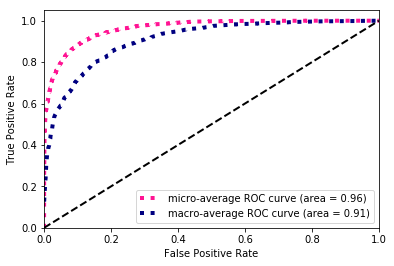

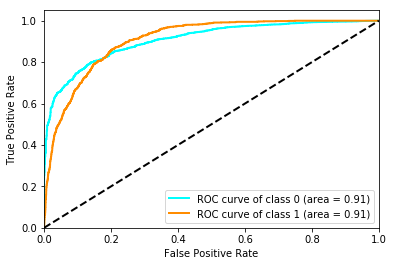

,0,1,macro avg,micro avg,weighted avg
index,,,,,
f1-score,0.937831,0.571963,0.754897,0.891431,0.889653
precision,0.932640,0.594752,0.763696,0.891431,0.888147
recall,0.943079,0.550855,0.746967,0.891431,0.891431
support,7326.000000,1111.000000,8437.000000,8437.000000,8437.000000
auc,0.907528,0.907528,0.907691,0.962780,NaN


In [29]:
Houston,dict_  =compare_models('Houston',w=[1,1])
save_dict (dict_,'Houston')

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 315)
(21102, 2)
(4385, 315)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

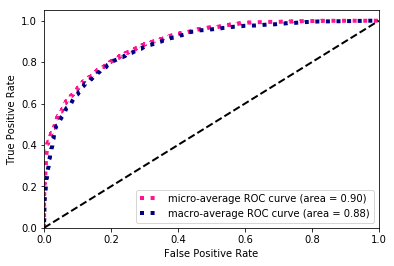

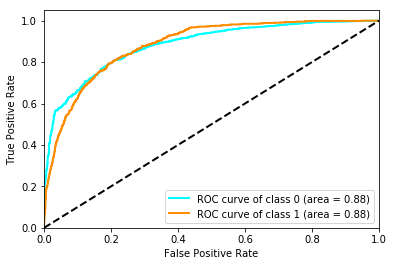

,0,1,macro avg,micro avg,weighted avg
index,,,,,
f1-score,0.864275,0.631356,0.747815,0.801596,0.814398
precision,0.934548,0.524279,0.729413,0.801596,0.846693
recall,0.803831,0.793397,0.798614,0.801596,0.801596
support,3446.000000,939.000000,4385.000000,4385.000000,4385.000000
auc,0.882721,0.882721,0.882973,0.895898,NaN


In [32]:
Charlotte,dict_  = compare_models('Charlotte',w=[1,1])
save_dict (dict_,'Charlotte')

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 315)
(26555, 2)
(5345, 315)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

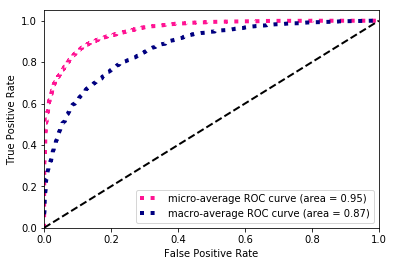

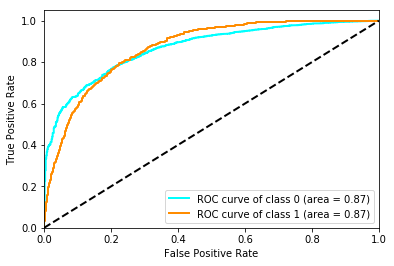

,0,1,macro avg,micro avg,weighted avg
index,,,,,
f1-score,0.930525,0.494191,0.712358,0.877830,0.879748
precision,0.935201,0.476831,0.706016,0.877830,0.881860
recall,0.925895,0.512862,0.719378,0.877830,0.877830
support,4723.000000,622.000000,5345.000000,5345.000000,5345.000000
auc,0.868371,0.868371,0.868688,0.952683,NaN


In [33]:
Dallas,dict_  = compare_models('Dallas',w=[1,1])
save_dict (dict_,'Dallas')